In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import contractions
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.models import *
from keras.layers import *

In [2]:
# Importing the datasets
train_data = pd.read_csv(r'Lyrics-Genre-Train.csv')
test_data = pd.read_csv(r'Lyrics-Genre-Test-GroundTruth.csv')

In [3]:
# Removing irrelevant columns from training and testing data
train_data = train_data.drop(['Song', 'Song year', 'Artist', 'Track_id'], axis=1)
test_data = test_data.drop(['Song', 'Song year', 'Artist', 'Track_id'], axis=1)

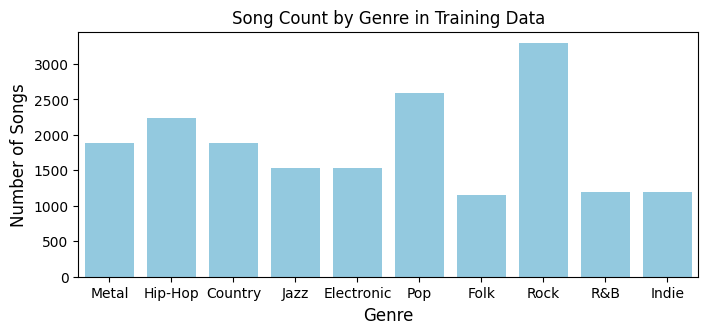

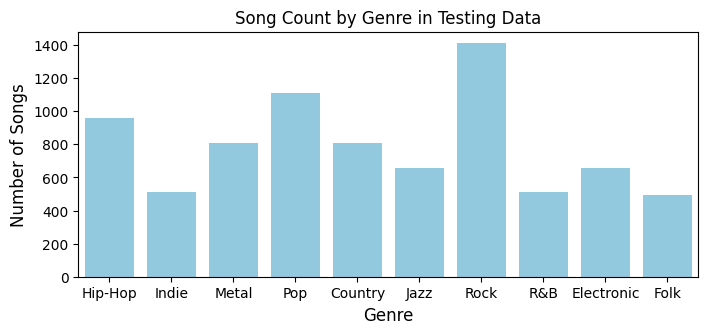

In [4]:
# Plotting songs count by genre for both datasets
plt.figure(figsize=(8,7))
plt.subplot(211)
sns.countplot(x='Genre', data=train_data, color='skyblue')
plt.title('Song Count by Genre in Training Data')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()
plt.figure(figsize=(8,7))
plt.subplot(212)
sns.countplot(x='Genre', data=test_data, color='skyblue')
plt.title('Song Count by Genre in Testing Data')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

In [5]:
train_data.drop(train_data.index[train_data['Genre'] == 'Folk'], inplace=True)
train_data.drop(train_data.index[train_data['Genre'] == 'R&B'], inplace=True)
train_data.drop(train_data.index[train_data['Genre'] == 'Indie'], inplace=True)

test_data.drop(test_data.index[test_data['Genre'] == 'Folk'], inplace=True)
test_data.drop(test_data.index[test_data['Genre'] == 'R&B'], inplace=True)
test_data.drop(test_data.index[test_data['Genre'] == 'Indie'], inplace=True)

In [6]:
def recall_score(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_score(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def clean(text):
    # convert text to lowercase
    text = text.lower()  
    # git red of non word carachters
    text = re.sub(r'\W', ' ', text)
    # remove digits
    text = re.sub(r'\d', ' ', text)
    # remove single carachters
    text = re.sub(r'\s+[a-z]\s+', ' ', text, flags=re.I)
    # remove single carachters at the start of the sentence 
    text = re.sub(r'^[a-z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'^\s', '', text) # space at beggining
    text = re.sub(r'\s$', '', text) # space at ending
    # Removing contractions "abbreviations"
    text = contractions.fix(text)
    # get rid of stopwords
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    # # Stemming words
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Lemmatizing words
#     lemmatizer = WordNetLemmatizer()
#     text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [8]:
# Apply clean function to the text
train_data["Lyrics"] = train_data["Lyrics"].apply(clean)
test_data["Lyrics"] = test_data["Lyrics"].apply(clean)

In [9]:
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=True)
df_train.reset_index()  

,index,Genre,Lyrics
0,3267,Metal,open eye find thing touch lost wait long time ...
1,136,Metal,blaze fire day damn ritual ancient summon dark...
2,12792,Jazz,peopl peopl need peopl luckiest peopl world ch...
3,457,Jazz,goodby mother sorri sorri heart long mother so...
4,11189,Rock,crazi goe million peopl live foe mayb late lea...
...,...,...,...
11979,6442,Pop,come manger see littl stranger wrap swaddl clo...
11980,16607,Electronic,erotik ist vorbei maschinen machen spass sex i...
11981,6709,Hip-Hop,choru big sean jhenã aiko got memori fade fade...
11982,1076,Country,wall never mean build tall lay awak wish fall ...


In [10]:
X_train = df_train['Lyrics'].values
X_val = df_val['Lyrics'].values
X_test = test_data['Lyrics'].values

In [11]:
def genre_encode(Genre):
    """
    return one hot encoding for Y value
    """
    if Genre == 'Pop':
        return 0
    elif Genre == 'Country':
        return 1
    elif Genre == 'Rock':
        return 2
    elif Genre == 'Hip-Hop':
        return 3
    elif Genre == 'Metal':
        return 4
    elif Genre == 'Jazz':
        return 5
    else:
        return 6

In [12]:
genres = df_train['Genre'].tolist()
y_train = [genre_encode(genre) for genre in genres]
y_train = np.array(y_train)

genres = df_val['Genre'].tolist()
y_val = [genre_encode(genre) for genre in genres]
y_val = np.array(y_val)

genres = test_data['Genre'].tolist()
y_test = [genre_encode(genre) for genre in genres]
y_test = np.array(y_test)

In [13]:
vectorizer = CountVectorizer(max_features=20000)
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [14]:
print('X_train shape :', X_train.shape)
print('X_val shape :', X_val.shape)
print('X_test shape :', X_test.shape)

X_train shape : (11984, 20000)
X_val shape : (2996, 20000)
X_test shape : (6420, 20000)


# ML Models

##  MultinomialNB Model

In [15]:
mn_model = MultinomialNB(alpha=.0433)
mn_model.fit(X_train, y_train)

MultinomialNB(alpha=0.0433)

In [16]:
accuracy = mn_model.score(X_train, y_train)
print(f'Accuracy on Training set: {accuracy:.5f}')

Accuracy on Training set: 0.74424


In [17]:
mn_pred = mn_model.predict(X_val)
accuracy = mn_model.score(X_val, y_val)
print(f'Accuracy on Validation set: {accuracy:.5f}')

Accuracy on Validation set: 0.48064


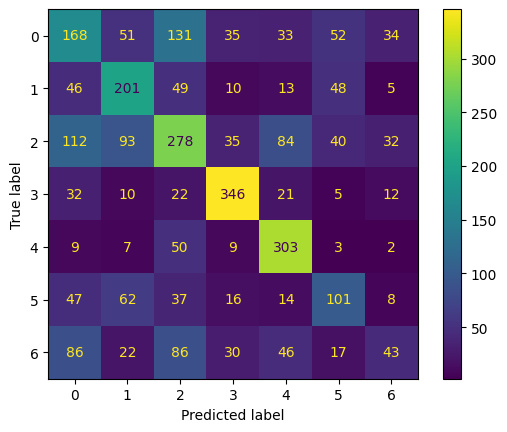

In [18]:
cm = confusion_matrix(y_val, mn_pred, labels=mn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mn_model.classes_)
disp.plot()
plt.show()

In [19]:
mn_pred = mn_model.predict(X_test)
accuracy = mn_model.score(X_test, y_test)
print(f'Accuracy on Test set: {accuracy:.5f}')

Accuracy on Test set: 0.50031


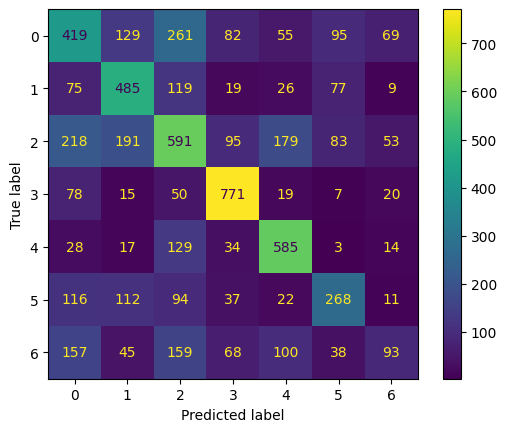

In [20]:
cm = confusion_matrix(y_test, mn_pred, labels=mn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mn_model.classes_)
disp.plot()
plt.show()

## Random Forest Classifier Model 

In [21]:
random_forest_model = RandomForestClassifier(n_estimators=300, criterion ='gini', max_depth = 20) 
random_forest_model = random_forest_model.fit(X_train,y_train)

In [22]:
accuracy = random_forest_model.score(X_train, y_train)
print(f'Accuracy on Training set: {accuracy:.5f}')

Accuracy on Training set: 0.57502


In [23]:
rf_pred = random_forest_model.predict(X_val)
accuracy = random_forest_model.score(X_val, y_val)
print(f'Accuracy on Validation set: {accuracy:.5f}')

Accuracy on Validation set: 0.42790


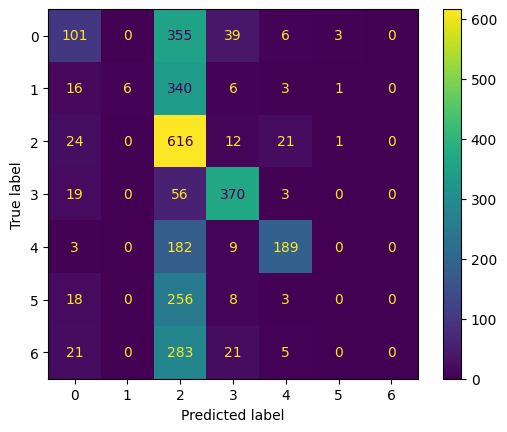

In [24]:
cm = confusion_matrix(y_val, rf_pred, labels=random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_forest_model.classes_)
disp.plot()
plt.show()

In [25]:
rf_pred = random_forest_model.predict(X_test)
accuracy = random_forest_model.score(X_test, y_test)
print(f'Accuracy on Test set: {accuracy:.5f}')

Accuracy on Test set: 0.41199


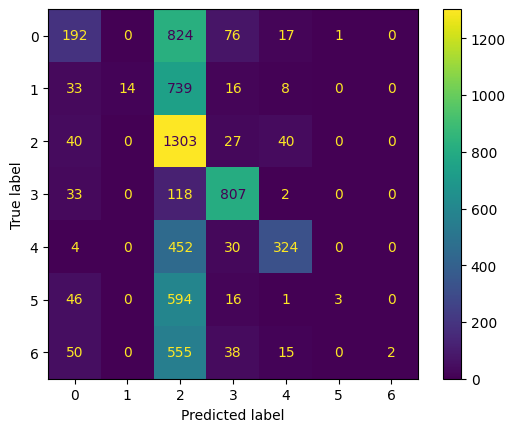

In [26]:
cm = confusion_matrix(y_test, rf_pred, labels=random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_forest_model.classes_)
disp.plot()
plt.show()

## SVC Model

In [27]:
svc_model = SVC() 
svc_model = svc_model.fit(X_train,y_train)

In [28]:
accuracy = svc_model.score(X_train, y_train)
print(f'Accuracy on Training set: {accuracy:.5f}')

Accuracy on Training set: 0.69484


In [29]:
svc_pred = svc_model.predict(X_val)
accuracy = svc_model.score(X_val, y_val)
print(f'Accuracy on Validation set: {accuracy:.5f}')

Accuracy on Validation set: 0.47363


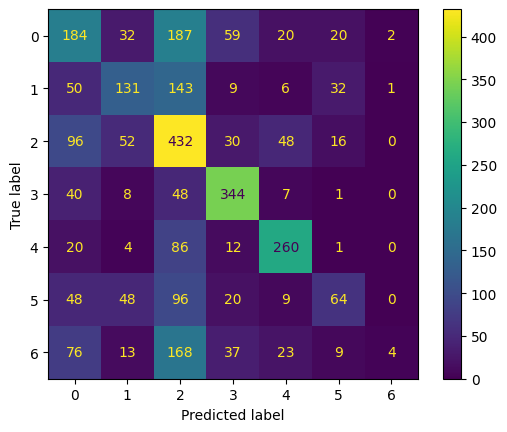

In [30]:
cm = confusion_matrix(y_val, svc_pred, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_model.classes_)
disp.plot()
plt.show()

In [31]:
svc_pred = svc_model.predict(X_test)
accuracy = svc_model.score(X_test, y_test)
print(f'Accuracy on Test set: {accuracy:.5f}')

Accuracy on Test set: 0.46729


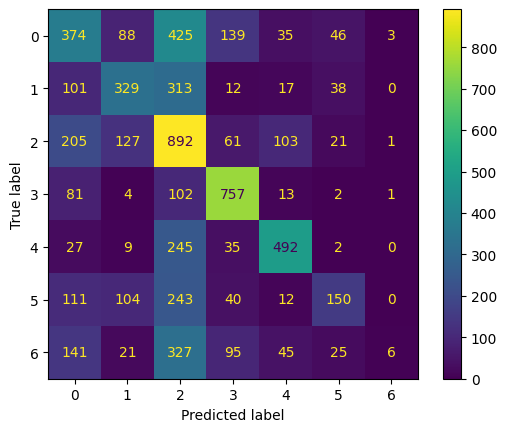

In [32]:
cm = confusion_matrix(y_test, svc_pred, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_model.classes_)
disp.plot()
plt.show()

## AdaBoost Classifier

In [33]:
AdaBoostClassifier_model = AdaBoostClassifier() 
AdaBoostClassifier_model = AdaBoostClassifier_model.fit(X_train,y_train)

In [34]:
accuracy = AdaBoostClassifier_model.score(X_train, y_train)
print(f'Accuracy on Training set: {accuracy:.5f}')

Accuracy on Training set: 0.41414


In [35]:
AdaBoostClassifier_pred = AdaBoostClassifier_model.predict(X_val)
accuracy = AdaBoostClassifier_model.score(X_val, y_val)
print(f'Accuracy on Validation set: {accuracy:.5f}')

Accuracy on Validation set: 0.41188


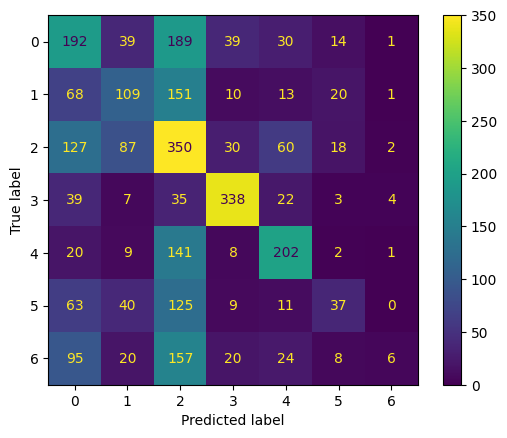

In [36]:
cm = confusion_matrix(y_val, AdaBoostClassifier_pred, labels=AdaBoostClassifier_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=AdaBoostClassifier_model.classes_)
disp.plot()
plt.show()

In [37]:
AdaBoostClassifier_pred = AdaBoostClassifier_model.predict(X_test)
accuracy = AdaBoostClassifier_model.score(X_test, y_test)
print(f'Accuracy on Test set: {accuracy:.5f}')

Accuracy on Test set: 0.40903


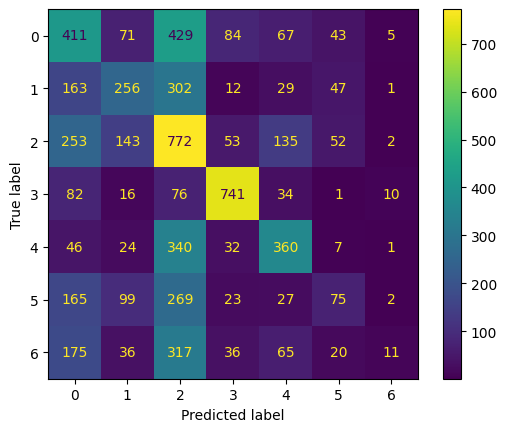

In [38]:
cm = confusion_matrix(y_test, AdaBoostClassifier_pred, labels=AdaBoostClassifier_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=AdaBoostClassifier_model.classes_)
disp.plot()
plt.show()

# Deep Learning Models

In [39]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

X_train.sort_indices()
X_val.sort_indices()
X_test.sort_indices()

In [45]:
dropout = 0.3
batch_size = 64
epochs = 15

# Model 1
# Build the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()

# # # Model 2
# # Build the model
# model = keras.Sequential()
# model.add(keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dense(7, activation='softmax'))
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               5120256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [46]:
# fitting the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15


C:\Users\lolyt\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


188/188 [==============================] - 11s 55ms/step - loss: 1.8085 - accuracy: 0.2671 - f1_score: 0.1095 - val_loss: 1.6654 - val_accuracy: 0.3431 - val_f1_score: 0.1795
Epoch 2/15
188/188 [==============================] - 14s 73ms/step - loss: 1.6483 - accuracy: 0.3464 - f1_score: 0.1932 - val_loss: 1.5389 - val_accuracy: 0.4119 - val_f1_score: 0.2448
Epoch 3/15
188/188 [==============================] - 12s 64ms/step - loss: 1.4819 - accuracy: 0.4322 - f1_score: 0.2877 - val_loss: 1.4552 - val_accuracy: 0.4523 - val_f1_score: 0.3064
Epoch 4/15
188/188 [==============================] - 12s 62ms/step - loss: 1.3208 - accuracy: 0.4968 - f1_score: 0.3713 - val_loss: 1.4786 - val_accuracy: 0.4599 - val_f1_score: 0.3432
Epoch 5/15
188/188 [==============================] - 12s 63ms/step - loss: 1.1734 - accuracy: 0.5463 - f1_score: 0.4352 - val_loss: 1.5572 - val_accuracy: 0.4563 - val_f1_score: 0.3501
Epoch 6/15
188/188 [==============================] - 12s 63ms/step - loss: 1.049

In [47]:
print('Training Accuracy')
a=model.evaluate(X_train,y_train)
print('Loss: {} \nAccuracy: {} \nF-1 Score: {}'.format(a[0],a[1],a[2]))

Training Accuracy
375/375 [==============================] - 2s 4ms/step - loss: 0.1268 - accuracy: 0.9635 - f1_score: 0.9643
Loss: 0.12683136761188507 
Accuracy: 0.9635347127914429 
F-1 Score: 0.9642754197120667


In [48]:
print('Validation Accuracy')
a=model.evaluate(X_val,y_val)
print('Loss: {} \nAccuracy: {} \nF-1 Score: {}'.format(a[0],a[1],a[2]))

Validation Accuracy
94/94 [==============================] - 0s 5ms/step - loss: 3.4292 - accuracy: 0.4599 - f1_score: 0.4581
Loss: 3.429175853729248 
Accuracy: 0.4599466025829315 
F-1 Score: 0.4580558240413666


In [49]:
print('Test Accuracy')
a=model.evaluate(X_test,y_test)
print('Loss: {} \nAccuracy: {} \nF-1 Score: {}'.format(a[0],a[1],a[2]))

Test Accuracy
201/201 [==============================] - 1s 5ms/step - loss: 3.7146 - accuracy: 0.4659 - f1_score: 0.4685
Loss: 3.714613676071167 
Accuracy: 0.4658878445625305 
F-1 Score: 0.468514621257782
